In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
def load_and_prepare_data(filename, header=False):
    res = pd.read_excel('../data/1Artembev_PhC_sport_and_tripms.xls', header=header)
    res = res[['Physiological Cost (PhC)', 'TRIMP1', 'TRIMP2', 'TRIMP3', 'TRIMP4', 'day number']]
    return res[11::]

In [3]:
artembev = load_and_prepare_data('../data/1Artembev_PhC_sport_and_tripms.xls', header=0)
artembev.head()

,Physiological Cost (PhC),TRIMP1,TRIMP2,TRIMP3,TRIMP4,day number
11,0.411155,802.127,138.638,1.23169,0,1.0
12,0.395014,1450.13,100.318,1341.57,579.98,2.0
13,0.392351,732.626,70.6103,2440.17,1695.58,3.0
14,NaN,809.691,13.2364,1778.61,880.455,4.0
15,0.408444,769.12,26.4721,1773.54,887.856,5.0


In [4]:
data = artembev.copy()
data.drop(columns=['day number'], inplace=True)
data["Physiological Cost (PhC)"] = data["Physiological Cost (PhC)"][1::]
cols_to_drop = []
for col in data.columns:
    data[col+'_mean_3_days'] = np.asarray([data.loc[i-1:i+1, col].mean() for i in data.index])
#     data.drop(columns=[col], inplace=True)
    cols_to_drop.append(col)
OLD_PHC_COLNAME = "Physiological Cost (PhC)_mean_3_days"
NEW_PHC_COLNAME = 'PhC_mean_target_3_days'
data[NEW_PHC_COLNAME] = data[OLD_PHC_COLNAME][3::].tolist() + 3*[np.nan]
data[OLD_PHC_COLNAME] = np.asarray([data.loc[i-2:i, "Physiological Cost (PhC)"].mean() for i in data.index])
# data['const'] = np.full(data.shape[0], 1)
# cols_to_drop.append(OLD_PHC_COLNAME)
data.drop(columns=cols_to_drop, inplace=True)
data.dropna(inplace=True)
data.head()

,Physiological Cost (PhC)_mean_3_days,TRIMP1_mean_3_days,TRIMP2_mean_3_days,TRIMP3_mean_3_days,TRIMP4_mean_3_days,PhC_mean_target_3_days
12,0.395014,994.960748,103.188621,1260.987536,758.520146,0.408444
13,0.393683,997.482226,61.388053,1853.448052,1052.005165,0.378842
14,0.393683,770.478993,36.772901,1997.440934,1154.630564,0.349240
15,0.400398,981.762669,177.930531,1626.721428,784.579500,0.372751
16,0.408444,958.164133,173.953128,1848.569418,1049.974340,0.396262


In [5]:
y = data[NEW_PHC_COLNAME]
X = data.drop(columns=[NEW_PHC_COLNAME])
X.columns, y.name

(Index(['Physiological Cost (PhC)_mean_3_days', 'TRIMP1_mean_3_days',
        'TRIMP2_mean_3_days', 'TRIMP3_mean_3_days', 'TRIMP4_mean_3_days'],
       dtype='object'), 'PhC_mean_target_3_days')

In [6]:
def train_and_test(X, y, max_depth=None, draw=False):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    X_train, X_test, y_train, y_test = X[:70], X[70:], y[:70], y[70:]
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree = tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    if draw:
        print(f'R^2 = {r2}')
        print(f'MAE = {mae}')
        plt.figure(figsize=(7,7))
        sns.scatterplot(y_test, y_pred)
    return r2, mae

In [7]:
def train_and_test_shuffled(X, y, max_depth=None, draw=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
#     X_train, X_test, y_train, y_test = X[:70], X[70:], y[:70], y[70:]
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree = tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    if draw:
        print(f'R^2 = {r2}')
        print(f'MAE = {mae}')
        plt.figure(figsize=(7,7))
        sns.scatterplot(y_test, y_pred)
    return r2, mae

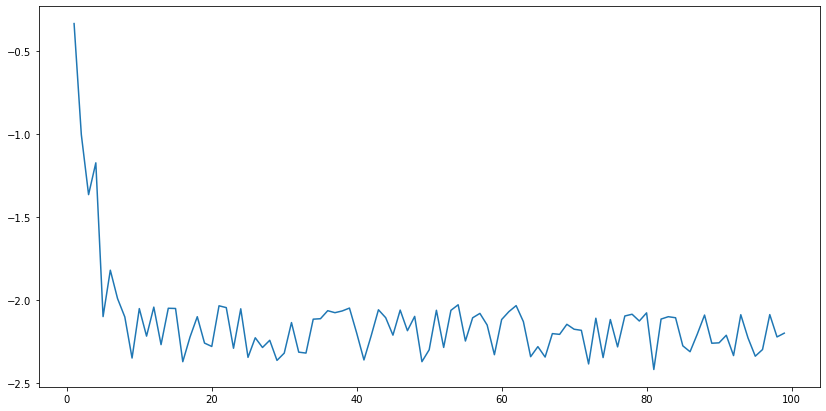

In [8]:
r_scores = []
depths = []
for i in range(1, 100):
    depths.append(i)
    r_scores.append(train_and_test(X, y, i)[0])
plt.figure(figsize=(14, 7))    
sns.lineplot(depths, r_scores)

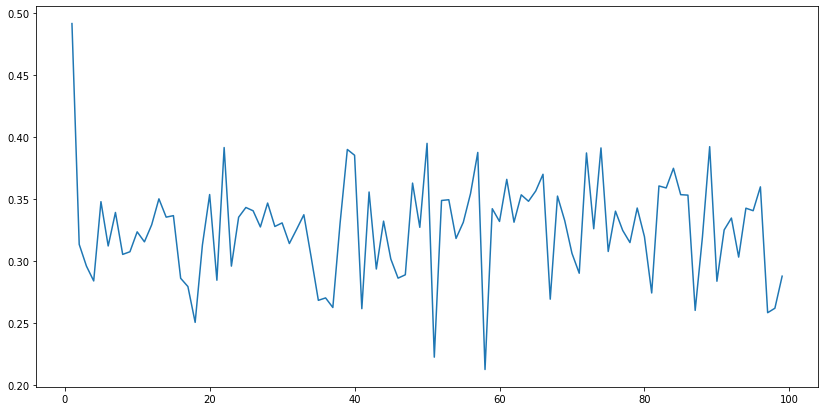

In [9]:
r_scores_shuffled = []
depths_shuffled = []
for i in range(1, 100):
    depths_shuffled.append(i)
    r_scores_shuffled.append(train_and_test_shuffled(X, y, i)[0])
plt.figure(figsize=(14, 7))    
sns.lineplot(depths_shuffled, r_scores_shuffled)

In [10]:
max_index = np.asarray(r_scores_shuffled).argmax()
print(f'Maximum R2 score = {r_scores_shuffled[max_index]}')
print(f'Corresponding tree depth is {depths_shuffled[max_index]}')

Maximum R2 score = 0.4917421118237927
Corresponding tree depth is 1


In [12]:
from sklearn.linear_model import LinearRegression
def train_and_test_shuffled_linear(X, y, draw=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
#     X_train, X_test, y_train, y_test = X[:70], X[70:], y[:70], y[70:]
    tree = LinearRegression()
    tree = tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    if draw:
        print(f'R^2 = {r2}')
        print(f'MAE = {mae}')
        print(f'regression coeficients are {tree.coef_}')
        print(f'intercept is {tree.intercept_}')
        plt.figure(figsize=(7,7))
        sns.scatterplot(y_test, y_pred)
    return r2, mae

R^2 = 0.4317978806020937
MAE = 0.01781487509855324
regression coeficients are [ 2.95814777e-02  2.21403972e-05 -6.66657670e-05  1.54515684e-06
  4.37210443e-07]
intercept is 0.3517545337370113


(0.4317978806020937, 0.01781487509855324)

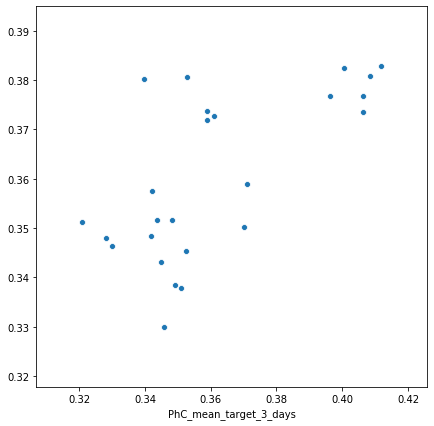

In [13]:
train_and_test_shuffled_linear(X, y, True)

In [54]:
from statsmodels.regression import linear_model as sm
import statsmodels.api as smapi

In [55]:
X = smapi.add_constant(X)
X.head()

,const,Physiological Cost (PhC)_mean_3_days,TRIMP1_mean_3_days,TRIMP2_mean_3_days,TRIMP3_mean_3_days,TRIMP4_mean_3_days
12,1.0,0.395014,994.960748,103.188621,1260.987536,758.520146
13,1.0,0.393683,997.482226,61.388053,1853.448052,1052.005165
14,1.0,0.393683,770.478993,36.772901,1997.440934,1154.630564
15,1.0,0.400398,981.762669,177.930531,1626.721428,784.579500
16,1.0,0.408444,958.164133,173.953128,1848.569418,1049.974340


In [56]:
result = sm.OLS(y, X).fit()
print(result.summary())

                              OLS Regression Results                              
Dep. Variable:     PhC_mean_target_3_days   R-squared:                       0.433
Model:                                OLS   Adj. R-squared:                  0.409
Method:                     Least Squares   F-statistic:                     18.03
Date:                    Sun, 05 Apr 2020   Prob (F-statistic):           2.95e-13
Time:                            21:03:19   Log-Likelihood:                 320.73
No. Observations:                     124   AIC:                            -629.5
Df Residuals:                         118   BIC:                            -612.5
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [58]:
artembev['Physiological Cost (PhC)'].mean()

0.3591327200652174